Idee:
- CNN Feature extraction + KDtree / altre distance measure (cosine?)
- Sift Keypoints
  - Different Matcher (BFMatcher, FlannBasedMatcher)
  - KDTree su features keypoints
- SURF
- Siamese Net

# Import dependencies

In [1]:
import numpy as np
from numpy.random import seed
import pandas as pd
import pickle

from numpy.core.fromnumeric import size

# Metriche e matrice di confusione
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, multilabel_confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# Image management
from skimage import io
from skimage.color.colorconv import rgb2gray

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree, BallTree
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from scipy.spatial.distance import euclidean

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow import keras
from keras import Sequential, Model
from keras import layers, regularizers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from keras.layers import Input, Flatten, Dense, Dropout, Reshape, Resizing, Rescaling, LeakyReLU, Lambda, Concatenate

from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input as ResNet50_preprocess_input

!pip install visualkeras
import visualkeras

import os
import re
import random

from os import path

import cv2 as cv
import matplotlib.pyplot as plt

from google.colab import files

# Seeds all randoms
cherrypicked_seed = 420
seed(cherrypicked_seed)
tf.random.set_seed(cherrypicked_seed)
random.seed(cherrypicked_seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 16.1 MB/s eta 0:00:00


# Connect to gDrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download dataset from kaggle

- Dataset [ https://www.kaggle.com/datasets/byildiz/amstertime ]
- Kaggle API instructions [ https://www.kaggle.com/general/74235 ] 

In [3]:
! pip install -q kaggle
from google.colab import files

# upload kaggle.json
# files.upload()

!mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
!cp /content/drive/MyDrive/ColabNotebooks/DSIM/Progetto/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download 'byildiz/amstertime'

import zipfile
with zipfile.ZipFile('amstertime.zip', 'r') as zip_ref:
    zip_ref.extractall('amstertime')

100% 871M/871M [00:43<00:00, 21.8MB/s]
100% 871M/871M [00:43<00:00, 21.1MB/s]


# Load and prepare data

In [9]:
base_path = 'amstertime/'

fn_new = np.sort(np.stack([base_path+'new/'+fn for fn in os.listdir(base_path+'new')]))
fn_old = np.sort(np.stack([base_path+'old/'+fn for fn in os.listdir(base_path+'old')]))

df = pd.DataFrame([[key, fold, fnew] for key,fold,fnew in zip(range(fn_old.shape[0]), fn_old, fn_new)], columns=['key', 'fn_old', 'fn_new'])

df

,key,fn_old,fn_new
0,0,amstertime/old/0000.jpg,amstertime/new/0000.png
1,1,amstertime/old/0001.jpg,amstertime/new/0001.png
2,2,amstertime/old/0002.jpg,amstertime/new/0002.png
3,3,amstertime/old/0003.jpg,amstertime/new/0003.png
4,4,amstertime/old/0004.jpg,amstertime/new/0004.png
...,...,...,...
1226,1226,amstertime/old/1363.jpg,amstertime/new/1363.png
1227,1227,amstertime/old/1364.jpg,amstertime/new/1364.png
1228,1228,amstertime/old/1365.jpg,amstertime/new/1365.png
1229,1229,amstertime/old/1366.jpg,amstertime/new/1366.png


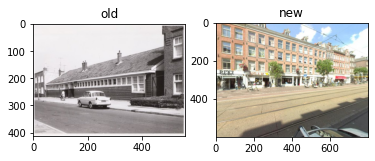

In [ ]:
# Attenzione alcune immagini 'old' sono in bianco nero, hanno solo un canale, quindi shape diverse da 'new'
# → utile prima trasformeare queste immagini b/w con 3 canali che sono uguali tra loro

plt.subplot(1,2,1); plt.imshow(io.imread(df.fn_old[0]), cmap='gray'); plt.title('old')
plt.subplot(1,2,2); plt.imshow(io.imread(df.fn_new[0])); plt.title('new')
plt.show()

# Utils

In [8]:
def save_pkl(filename, obj):
  with open(filename, 'wb') as f:
    pickle.dump(obj, f)
  # return filename

def load_pkl(filename):
  with open(filename, 'rb') as f:
    obj = pickle.load(f)
  return obj

def imresize(img, size=(450,380), interp=cv.INTER_LINEAR):
  # (380,450) = avg shape for old imgs
  return cv.resize(img, dsize=size, interpolation=interp)

def load_imgs(old_new, size=None, gray=True, first_n = 400):
  impaths = df.fn_new if old_new=='new' else df.fn_old
  if first_n>0:
    impaths = impaths[:first_n]
  imgs = [io.imread(imp) for imp in impaths]
  if gray:
    imgs = [rgb2gray(im[:,:,:3]) if len(im.shape)>2 else im for im in imgs]
  if size != None:
    imgs = np.stack([imresize(im, size) for im in imgs])
  return imgs

def load_imgs_source(df_source, old_new, size=None, gray=True, first_n = 400, three_channels=False):
  impaths = df_source.fn_new if old_new=='new' else df_source.fn_old
  if first_n>0:
    impaths = impaths[:first_n]
  imgs = [io.imread(imp) for imp in impaths]
  if gray:
    imgs = [rgb2gray(im[:,:,:3]) if len(im.shape)>2 else im for im in imgs]
  if size != None:
    imgs = np.stack([imresize(im, size) for im in imgs])
  if len(imgs.shape)<4 and three_channels:
    imgs = np.stack([cv.merge([im,im,im]) for im in imgs])
  return imgs

def compute_sift(imgs, sifter, rescale255=True):
  if rescale255:
    imgs = [(im*255.0/im.max()).astype('uint8') for im in imgs]
  sift_output = [sifter.detectAndCompute(im, None) for im in imgs]
  kbp = [sift_out[0] for sift_out in sift_output]
  feats = [sift_out[1] for sift_out in sift_output]
  return kbp, feats

def sift_matches(q, database, matchf, return_dict=True):
  dict_matches = {idx_item: matchf(q, item) for idx_item, item in enumerate(database)}
  return dict_matches if return_dict else list(dict_matches.values())

def sift_match_filter_by_lowes(matches, wlowes):
  return {key:[m for m,n in qmatch if m.distance < wlowes*n.distance] for key,qmatch in matches.items()}

def match_by_sift_kps(query, database, query_function, wlowes, sort_metric, topk):
  qmatches = sift_matches(query, database, query_function)
  qmatchesf = sift_match_filter_by_lowes(qmatches, wlowes)
  qmatches_m = sort_value(qmatchesf, sortf=sort_metric)
  qmatches_topk = np.array(list(qmatches_m.keys())[:topk])
  return qmatches_topk

def sort_value(d, reverse=True, sortf=lambda item: item[1]):
    return dict(sorted(d.items(), key=sortf, reverse=reverse))

def split_im_grid(im, grid_size=3):
  M = im.shape[0]//3
  N = im.shape[1]//3
  tiles = np.stack([im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)])
  return tiles

def resnet50_extract_feature(im):
  im = imresize(im)
  im = cv.merge((im, im, im))
  im = ResNet50_preprocess_input(im)
  im = np.expand_dims(im, axis=0)
  im = resnet50.predict(im)
  feats = im.flatten()
  return feats

def resnet_tiles_wmean(tiles, weights):
  return np.stack([sum([tile[iw]*w for iw,w in enumerate(weights)])/sum(weights) for tile in tiles])

def vector_sum(vectors):
  return np.sum(vectors, axis=0)

def compute_custom_vlad_residuals(img_feats, img_feats_cl, cluster_model, num_clusters, distance=euclidean):
  # !!! Interpretazione errata, distanza è differenza punto-punto non dist. euclidea
  img_feats_membership_dict = { w : [feat for feat_idx,feat in enumerate(img_feats) if img_feats_cl[feat_idx]==w] for w in range(num_clusters) }
  feat_residuals = np.array([ sum([ distance(feat_member, cluster_model.cluster_centers_[w]) for feat_member in img_feats_membership_dict[w]]) for w in range(num_clusters) ])
  return feat_residuals

def compute_vlad_residuals(img_feats, img_feats_cl, cl_model, num_clusters, normalize=False):
  img_feats_membership_dict = { w : [feat for feat_idx,feat in enumerate(img_feats) if img_feats_cl[feat_idx]==w] for w in range(num_clusters) }
  feat_residuals = [[feat_member - cluster_model.cluster_centers_[w] for feat_member in img_feats_membership_dict[w]] for w in range(num_clusters)]
  feat_residuals = [cl_residuals if len(cl_residuals)>0 else np.stack([[np.finfo(np.float32).max for _ in range(num_clusters)]]) for cl_residuals in feat_residuals]
  if normalize:
    feat_residuals = [[(res / np.linalg.norm(res)) for res in cl_residuals] for cl_residuals in feat_residuals]
  feat_residuals = np.stack([vector_sum(cl_residuals) for cl_residuals in feat_residuals])
  if normalize:
    feat_residuals = np.stack([(cl_residuals-cl_residuals.mean())/cl_residuals.std() for cl_residuals in feat_residuals])
  return feat_residuals

def tree_query(tree, query_features, k=1):
  dist, ind = tree.query(query_features, k=k)
  return dist, ind

def build_wrong_pairs(fname1, fname2, pair_for_each=3):
  all_pairs = []
  for i,fn_old in enumerate(fname1):
    pairs = []
    not_assoc = [fn_old[15:19]]
    imname = not_assoc[0]
    for ncoppia in range(pair_for_each):
      impath = None
      while imname in not_assoc:
        impath = random.choice(fname2)
        imname = impath[15:19]
      pairs.append([fn_old, impath])
      not_assoc.append(impath[15:19])
    all_pairs.extend(pairs)
  return all_pairs

def compute_tfidf(img_feats, img_feats_cl, cl_model, num_clusters, all_feats_cl):
  img_feats_membership_dict = { w : [feat for feat_idx,feat in enumerate(img_feats) if img_feats_cl[feat_idx]==w] for w in range(num_clusters) }
  tf = {w: len(m)/num_clusters for w,m in img_feats_membership_dict.items()}
  idf = {w: math.log10(len(all_feats_cl) / sum([1 for feat_cl in all_feats_cl if w in feat_cl])) for w,m in img_feats_membership_dict.items()}
  tfidf = {w: tf[w]*idf[w] for w in range(k)}
  return np.array(list(tfidf.values()))

def mean_dist(feats, centroid):
  dists = np.array([euclidean(f, centroid) for f in feats])
  if len(feats)==0:
    return 0
  else:
    distm = dists.mean()
    if distm == 0:
      return 0.0001
    else:
      return distm

def compute_tfidf_mod(img_feats, img_feats_cl, cl_model, num_clusters, all_feats_cl):
  img_feats_membership_dict = { w : [feat for feat_idx,feat in enumerate(img_feats) if img_feats_cl[feat_idx]==w] for w in range(num_clusters) }
  tf = {w: (len(m)/(num_clusters*mean_dist(m, cl_model.cluster_centers_[w])) if mean_dist(m, cl_model.cluster_centers_[w])>0 else 0) for w,m in img_feats_membership_dict.items()}
  idf = {w: math.log10(len(all_feats_cl) / sum([len([1 for fcl in feat_cl if w==fcl]) for feat_cl in all_feats_cl if w in feat_cl])) for w,m in img_feats_membership_dict.items()}
  tfidf = {w: tf[w]*idf[w] for w in range(k)}
  return np.array(list(tfidf.values()))

# IR with SIFT detectors

**Method:**
1. Compute SIFT on each images in 'new' and 'old' set
2. For each old image compute matches on each new image
3. Discard keypoints-matches by *Lowe's ratio*
4. Sort matched images by custom measure (1!)
5. Extract first N matched images (2!)
6. Evaluate matches

**Note:**
- (1!) Sorting method:
    - Similarity sum
    - Similarity average
    - N° of matched keypoints
- (2!) Extracting first n-images:
    - Top-K (K = 1/3/5/10)
    - Threshold on measure used for sorting method

## 1. Prepare images

In [ ]:
# Read images

first_n_imgs = 400

imgs_old = load_imgs('old', size=(450,380), gray=True, first_n = first_n_imgs)
imgs_new = load_imgs('new', size=None, gray=True, first_n = first_n_imgs)

## 2. Compute SIFT keypoints

In [ ]:
# Compute SIFT

sift = cv.SIFT_create()

kbp_old, feats_old = compute_sift(imgs_old, sift, rescale255=True)
kbp_new, feats_new = compute_sift(imgs_new, sift, rescale255=True)

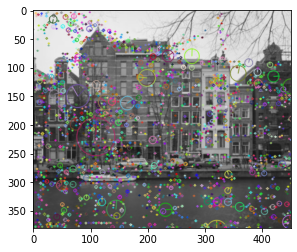

In [ ]:
# SIFT keypoints visualization
idx = 1
box_kps = cv.drawKeypoints(imgs_old[idx].astype('uint8'), kbp_new[idx], None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(box_kps); plt.show()

## 3. Init key-points matcher

In [ ]:
flann_matcher = cv.FlannBasedMatcher(dict(algorithm = 1, trees = 5), dict(checks = 50))
flann_matcher_fmatch = lambda query,item: flann_matcher.knnMatch(query,item, k=2)

## 4. Rapid test

In [ ]:
idx_test = 190
qmatches = sift_matches(feats_old[idx_test], feats_new, lambda query,item: flann_matcher.knnMatch(query,item, k=2))

In [ ]:
def match_by_sift_kps(query, database, query_function, wlowes, sort_metric, topk):
  qmatches = sift_matches(query, database, lambda query,item: flann_matcher.knnMatch(query,item, k=2))
  qmatchesf = sift_match_filter_by_lowes(qmatches, wlowes)
  qmatches_m = sort_value(qmatchesf, sortf=sort_metric)
  qmatches_topk = np.array(list(qmatches_m.keys())[:topk])
  return qmatches_topk

In [ ]:
# Filter all the good matches as per Lowe's ratio

qmatchesf = sift_match_filter_by_lowes(qmatches, 0.5)

In [ ]:
# Define custom metrics for sorting matches

metric1_n_matches = lambda kp_match: len(kp_match[1])
metric2_sum_of_distances = lambda kp_match: sum([kp.distance for kp in kp_match[1]])
metric3_mean_of_distances = lambda kp_match: np.array([kp.distance for kp in kp_match[1]]).mean() if len(kp_match[1])>0 else 0

In [ ]:
# Sort matches by custom metrics

qmatches1 = sort_value(qmatchesf, sortf=metric1_n_matches)
qmatches2 = sort_value(qmatchesf, sortf=metric2_sum_of_distances)
qmatches3 = sort_value(qmatchesf, sortf=metric3_mean_of_distances)

In [ ]:
print('Metric \'n_matches\' matched at position:\t\t', list(qmatches1.keys()).index(idx_test))
print('Metric \'sum_of_distances\' matched at position:\t', list(qmatches2.keys()).index(idx_test))
print('Metric \'mean_of_distances\' matched at position:\t', list(qmatches3.keys()).index(idx_test))

# CNN Features

## Prepare images

### Standard mode

In [ ]:
# Define image number

first_n_imgs = 400

In [ ]:
# Read images

imgs_old = load_imgs('old', size=(450,380), gray=True, first_n = first_n_imgs)
imgs_new = np.stack(load_imgs('new', size=None, gray=True, first_n = first_n_imgs))

<ipython-input-55-0ee22b337930>:21: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  imgs = [rgb2gray(im) for im in imgs]
<ipython-input-55-0ee22b337930>:21: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  imgs = [rgb2gray(im) for im in imgs]


### Grid 3x3 system
locVLAD inspired

In [ ]:
# Load images with shapes // 3

first_n_imgs = 400

imgs_old = load_imgs('old', size=(450,381), gray=True, first_n = first_n_imgs)
imgs_new = load_imgs('new', size=(801,600), gray=True, first_n = first_n_imgs)

<ipython-input-7-2f41ae35eafd>:21: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  imgs = [rgb2gray(im) for im in imgs]
<ipython-input-7-2f41ae35eafd>:21: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  imgs = [rgb2gray(im) for im in imgs]


In [ ]:
imgs_tiles_old = np.stack([split_im_grid(im, grid_size=3) for im in imgs_old])
imgs_tiles_new = np.stack([split_im_grid(im, grid_size=3) for im in imgs_new])

## Build features extractor

In [ ]:
resnet50 = ResNet50(
    input_shape=(380,450,3),
    include_top=False,
    weights="imagenet",
    pooling='max'
)

## Extract features

### Standard mode

In [ ]:
resnet50_imgs_old_feats = np.stack([resnet50_extract_feature(im) for im in imgs_old])
resnet50_imgs_new_feats = np.stack([resnet50_extract_feature(im) for im in imgs_new])

In [ ]:
# Save pickle

resnet50_imgs_old_feats_fname = 'resnet50_imgs_old_feats_first'+str(first_n_imgs)+'.pickle'
resnet50_imgs_new_feats_fname = 'resnet50_imgs_new_feats_first'+str(first_n_imgs)+'.pickle'

# _ = save_pkl(resnet50_imgs_old_feats_fname, resnet50_imgs_old_feats)
# _ = save_pkl(resnet50_imgs_new_feats_fname, resnet50_imgs_new_feats)

In [ ]:
# Load pickle

resnet50_pkl_path = '/content/drive/MyDrive/ColabNotebooks/DSIM/Progetto/IR_pickle/pkl_resnet/'

resnet50_imgs_old_feats = load_pkl(resnet50_pkl_path + resnet50_imgs_old_feats_fname)
resnet50_imgs_new_feats = load_pkl(resnet50_pkl_path + resnet50_imgs_new_feats_fname)

In [ ]:
resnet50_tree = KDTree(resnet50_imgs_new_feats, leaf_size=20, metric='minkowski')

### Grid 3x3 system

In [ ]:
# Extract features for each tile, for each image

resnet50_imgs_tiles_old_feats = np.stack([[resnet50_extract_feature(tile) for tile in im] for im in imgs_tiles_old])
resnet50_imgs_tiles_new_feats = np.stack([[resnet50_extract_feature(tile) for tile in im] for im in imgs_tiles_new])

In [ ]:
# Save pickle

resnet50_imgs_tiles_old_feats_fname = 'resnet50_imgs_tiles9_old_feats_first'+str(first_n_imgs)+'.pickle'
resnet50_imgs_tiles_new_feats_fname = 'resnet50_imgs_tiles9_new_feats_first'+str(first_n_imgs)+'.pickle'

# _ = save_pkl(resnet50_imgs_tiles_old_feats_fname, resnet50_imgs_tiles_old_feats)
# _ = save_pkl(resnet50_imgs_tiles_new_feats_fname, resnet50_imgs_tiles_new_feats)

In [ ]:
# Load pickle

resnet50_pkl_path = '/content/drive/MyDrive/ColabNotebooks/DSIM/Progetto/IR_pickle/pkl_resnet/'

resnet50_imgs_tiles_old_feats = load_pkl(resnet50_pkl_path + resnet50_imgs_tiles_old_feats_fname)
resnet50_imgs_tiles_new_feats = load_pkl(resnet50_pkl_path + resnet50_imgs_tiles_new_feats_fname)

#### Compute weighted mean of tiles

Tiles are weighted by an inspired gaussian-filter weights

- features_tiles_9 = [[F1], [F2], [F3], [F4], [F5], [F6], [F7], [F8], [F9]] <br>
- features_weights = [[1], [2], [1], [2], [4], [2], [1], [2], [1]] → w.sum = 16

In [ ]:
weights = np.array([1,2,1, 2,4,2, 1,2,1])

##### Weighted mean only

In [ ]:
resnet50_imgs_tiles_w_mean_old_feats = resnet_tiles_wmean(resnet50_imgs_tiles_old_feats, weights)
resnet50_imgs_tiles_w_mean_new_feats = resnet_tiles_wmean(resnet50_imgs_tiles_new_feats, weights)

In [ ]:
resnet50_tree_tiles_w_mean = KDTree(resnet50_imgs_tiles_w_mean_new_feats, leaf_size=20, metric='minkowski')

##### Custom LocCNNFeatures
Weighted mean features + full image features

In [ ]:
loc_w = {'wloc':0.7, 'wfull':0.3}

resnet50_imgs_tiles_loc_w_mean_old_feats = resnet50_imgs_tiles_w_mean_old_feats*loc_w['wloc'] + resnet50_imgs_old_feats*loc_w['wfull']
resnet50_imgs_tiles_loc_w_mean_new_feats = resnet50_imgs_tiles_w_mean_new_feats*loc_w['wloc'] + resnet50_imgs_new_feats*loc_w['wfull']

In [ ]:
resnet50_tree_tiles_loc_w_mean = KDTree(resnet50_imgs_tiles_loc_w_mean_new_feats, leaf_size=20, metric='minkowski')

##### Standard LocCNNFeature 

Mean central tile + full image

In [ ]:
loc_w = {'wloc':0.5, 'wfull':0.5}

resnet50_imgs_central_loc_w_mean_old_feats = resnet50_imgs_tiles_old_feats[:,4,:]*loc_w['wloc'] + resnet50_imgs_old_feats*loc_w['wfull']
resnet50_imgs_central_loc_w_mean_new_feats = resnet50_imgs_tiles_new_feats[:,4,:]*loc_w['wloc'] + resnet50_imgs_new_feats*loc_w['wfull']

In [ ]:
resnet50_tree_central_loc_w_mean = KDTree(resnet50_imgs_central_loc_w_mean_new_feats, leaf_size=20, metric='minkowski')

## Rapid test

In [ ]:
idx_test = 1
qfeats = np.expand_dims(resnet50_extract_feature(imgs_old[idx_test]), axis=0)

1/1 [==============================] - 0s 21ms/step


In [ ]:
matches = tree_query(resnet50_tree, qfeats, k=30)

In [ ]:
matches

(array([[250.43086441, 250.64395695, 250.87522901, 251.03677836,
         251.0631254 , 251.12571699, 251.13919468, 251.14449291,
         251.16621073, 251.18251545, 251.20092522, 251.21877593,
         251.23839655, 251.25553903, 251.25553903, 251.31476511,
         251.35996046, 251.37331844, 251.43131997, 251.43479482,
         251.43581913, 251.45341154, 251.4620756 , 251.4942462 ,
         251.51679747, 251.52357268, 251.52848151, 251.53168451,
         251.53524571, 251.53661389]]),
 array([[351,  98, 263, 369,  64, 171, 255,  25, 102, 256,  65, 158,  94,
         374, 372, 278,  56, 370,  49, 265, 146,  72, 361, 211, 345, 398,
         387,  68,  80,  43]]))

# VLAD descriptors

**Papers:**
- SIFT Meets CNN: A Decade Survey of Instance Retrieval [ https://arxiv.org/pdf/1608.01807.pdf ]
- A Dense-Depth Representation for VLAD descriptors in Content-Based Image Retrieval [ https://arxiv.org/pdf/1808.05022.pdf ] 
<br><br>

**Method:**
1. Costruire Codebook C = { w(1), ..., w(k) } con K=64/128/256/512 tramite tutte le feature di tutte le immagini (train set 80%) (valutare dimensione k clusters tramite misure interne (e.g. silouette) (!0)
2. Estrazione per ogni immagine dell'insieme di feature X = { x(1), ..., x(m) }
3. Per ogni w(j) j in 1..k , si computa v(j) pari alla sommatoria degli scarti delle feature x(i) appartenentia w(j) da c(j) pari al centroide di w(j) (!1)
4. Usare signature dell'immagine (V = [ [ v(1.1), ..., v(1.m) ], .., [v(k.1), ..., v(k.m)] ]) per image retrieval  (!2 !3 !4)

**Note:**
- (!0) Utilizzo metodo per clustering (KMeans base, ...?)
- (!1) Definizione di scarto: differenza vettoriale punto a punto
- (!2) Valuatre se c'è guadagno in misure di seprazione interne (Silouette, ..?)
- (!3) Valutare normalizzazione e/o riduzuione dimensione (PCA, SVD, TNSE ..?)
- (!4) Scegliere misura similarità per IR (KDTree, distanze, ...?)


## 1. Build codebook

### Prepare data features

In [ ]:
# Read images

first_n_imgs = 400

imgs_old = load_imgs('old', size=(450,380), gray=True, first_n = first_n_imgs)
imgs_new = load_imgs('new', size=None, gray=True, first_n = first_n_imgs)

In [ ]:
# Compute SIFT

sift = cv.SIFT_create()

feats_old = compute_sift(imgs_old, sift, rescale255=True)[1]
feats_new = compute_sift(imgs_new, sift, rescale255=True)[1]

### Build cluster space

In [ ]:
# Cluster number

k = 128

In [ ]:
# Clustering parameters

cluster_model = KMeans(n_clusters=k, random_state=cherrypicked_seed)
# cluster_model = GaussianMixture(n_components=k, random_state=cherrypicked_seed)

In [ ]:
# Prepare features

# cl_features_old = np.concatenate([np.stack(feat) for feat in feats_old], axis=0)
# cl_features_new = np.concatenate([np.stack(feat) for feat in feats_new], axis=0)
cl_features = np.concatenate((
                                np.concatenate([np.stack(feat) for feat in feats_old], axis=0), 
                                np.concatenate([np.stack(feat) for feat in feats_new], axis=0)
                             ), axis=0)

In [ ]:
# Run cluster

cluster_model.fit(cl_features)

In [ ]:
# Save cluster

clfname = 'cluster_gmm'+str(k)+'_sift_oldnew_first'+str(first_n_imgs)+'.pickle'
_ = save_pkl(clfname, cluster_model)

In [ ]:
cluster_model.cluster_centers_.shape

(128, 128)

In [ ]:
# Load pickle

# Replace with your path
cluster_model_path = '/content/drive/MyDrive/ColabNotebooks/DSIM/Progetto/IR_pickle/pkl_vlad_kmeans/'

cluster_model = load_pkl(cluster_model_path + 'cluster_kmeans128_sift_oldnew_first400.pickle')

## 2. Apply cluster to images features

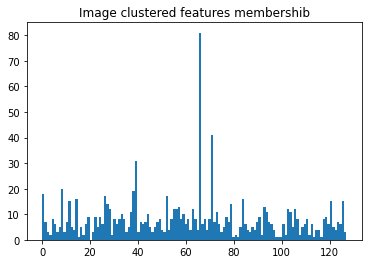

In [ ]:
# Extract features labels for each image
# List of features membership for each image. 
  # → Each element is referred to an image features list
    # → Each element is referred to a feature label

feats_cl_old = [cluster_model.predict(feat) for feat in feats_old]
feats_cl_new = [cluster_model.predict(feat) for feat in feats_new]

plt.hist(feats_cl_old[0], bins=k); _ = plt.title('Image clustered features membershib')

## 3. Compute VLAD descriptors

Normalized by Formula (4) and (5) pag.4 in [ https://arxiv.org/pdf/1808.05022.pdf ]

In [ ]:
vlad_old = np.stack([compute_vlad_residuals(img_feats, img_feats_cl, cluster_model, k, normalize=True) for img_feats,img_feats_cl in zip(feats_old, feats_cl_old)])
vlad_new = np.stack([compute_vlad_residuals(img_feats, img_feats_cl, cluster_model, k, normalize=True) for img_feats,img_feats_cl in zip(feats_new, feats_cl_new)])

In [ ]:
# Save pickle

vladfname_old = 'vlad_normalized_kmeans'+str(k)+'_sift_old_first'+str(first_n_imgs)+'.pickle'
vladfname_new = 'vlad_normalized_kmeans'+str(k)+'_sift_new_first'+str(first_n_imgs)+'.pickle'

_ = save_pkl(vladfname_old, vlad_old)
_ = save_pkl(vladfname_new, vlad_new)

In [ ]:
# Load pickles

vladfname_old = 'vlad_normalized_kmeans'+str(k)+'_sift_old_first'+str(first_n_imgs)+'.pickle'
vladfname_new = 'vlad_normalized_kmeans'+str(k)+'_sift_new_first'+str(first_n_imgs)+'.pickle'

vlad_path = '/content/drive/MyDrive/ColabNotebooks/DSIM/Progetto/IR_pickle/pkl_vlad_kmeans/'

vlad_old = load_pkl(vlad_path + vladfname_old)
vlad_new = load_pkl(vlad_path + vladfname_new)

In [ ]:
vlad_old[np.isnan(vlad_old)] = 0
vlad_new[np.isnan(vlad_new)] = 0
vlad_old[np.isinf(vlad_old)] = np.finfo('float64').max
vlad_new[np.isinf(vlad_new)] = np.finfo('float64').max

### 4. Rapid test 

In [ ]:
# Prepare features

vlad_flat_old = np.stack([vlad.flatten() for vlad in vlad_old])
vlad_flat_new = np.stack([vlad.flatten() for vlad in vlad_new])

In [ ]:
# Test Trees search

vlad_new_balltree = BallTree(vlad_flat_new, leaf_size=40, metric='minkowski')
vlad_new_kdtree = KDTree(vlad_flat_new, leaf_size=40, metric='minkowski')

In [ ]:
test_idx = 1

BLmatches = tree_query(vlad_new_balltree, [vlad_flat_old[test_idx]], k=30)
KDmatches = tree_query(vlad_new_kdtree, [vlad_flat_old[test_idx]], k=30)

print('Ball Match:\t', np.any(np.isin(BLmatches[1], test_idx)), '\t → Find at position: ' + str(np.where(BLmatches[1] == test_idx)[1]) if np.any(np.isin(BLmatches[1], test_idx)) else '')
print('KD Match:\t', np.any(np.isin(KDmatches[1], test_idx)), '\t → Find at position: ' + str(np.where(KDmatches[1] == test_idx)[1]) if np.any(np.isin(KDmatches[1], test_idx)) else '')

Ball Match:	 True 	 → Find at position: [0]
KD Match:	 True 	 → Find at position: [0]


# Siamese Net

## Prepare images

In [ ]:
# Define image number

first_n_imgs = 400
df = df.iloc[:first_n_imgs]

In [ ]:
fn_false_pairs = np.array(build_wrong_pairs(df.fn_old, df.fn_new, 3))
fn_true_pairs = df[['fn_old', 'fn_new']].to_numpy()
fn_pairs = np.concatenate((fn_false_pairs, fn_true_pairs))

In [ ]:
df_pairs = pd.DataFrame(fn_pairs, columns=['fn_old', 'fn_new'])
df_pairs['label'] = df_pairs.apply(lambda p: 1 if p.fn_old[15:19]==p.fn_new[15:19] else 0, axis=1)

In [ ]:
df_pairs = df_pairs.sample(frac=1).reset_index(drop=True)

In [ ]:
x_fn_train, x_fn_test, y_train, y_test = train_test_split(df_pairs[['fn_old', 'fn_new']], df_pairs.label, test_size=0.1, stratify=df_pairs.label, random_state=cherrypicked_seed)
x_fn_train, x_fn_val, y_train, y_val = train_test_split(x_fn_train, y_train, test_size=0.1, stratify=y_train, random_state=cherrypicked_seed)

In [ ]:
target_shape = (108,128,3)

In [ ]:
x_train_old = load_imgs_source(x_fn_train, 'old', size=target_shape[:2][::-1], gray=True, first_n = -1, three_channels=True)
x_train_new = load_imgs_source(x_fn_train, 'new', size=target_shape[:2][::-1], gray=True, first_n = -1, three_channels=True)
y_train = tf.cast(y_train, tf.float32)

x_val_old = load_imgs_source(x_fn_val, 'old', size=target_shape[:2][::-1], gray=True, first_n = -1, three_channels=True)
x_val_new = load_imgs_source(x_fn_val, 'new', size=target_shape[:2][::-1], gray=True, first_n = -1, three_channels=True)
y_val = tf.cast(y_val, tf.float32)

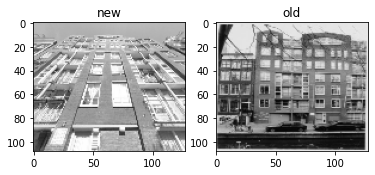

In [ ]:
plt.subplot(1,2,1); plt.imshow(x_train_new[0]); plt.title('new')
plt.subplot(1,2,2); plt.imshow(x_train_old[0]); plt.title('old')
plt.show()

## Build network

### Utils

In [ ]:
def build_input_section(inputs, preprocess_input_layer, do_normalization = False):
  if do_normalization:
    inputs = Rescaling(1./255)(inputs)
  outputs = preprocess_input_layer(inputs)
  return outputs

def build_output_section(inputs):
  x = layers.GlobalAveragePooling2D()(inputs) 
  outputs = Flatten()(x)
  return outputs

def trim_model(model, layer_name): 
  return Model(inputs = model.input, outputs = model.get_layer(layer_name).output)

def freeze_model(model, freeze_until_layer=None):
  freeze_until_idx = [i for i,layer in enumerate(model.layers) if layer.name==freeze_until_layer][0] if freeze_until_layer!=None else len(model.layers)+1
  for layer_idx,layer in enumerate(model.layers):
    layer.trainable = False if layer_idx <= freeze_until_idx else True
  return model

# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
@tf.function
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

def plot_history(history): 
  fig = make_subplots(rows = 1, cols = 2, subplot_titles = ["Loss", "Accuracy"]) 
  fig.add_trace(go.Scatter(y = history.history['val_loss'], name = "val_loss"), row = 1, col = 1,) 
  fig.add_trace(go.Scatter(y = history.history['loss'], name = "loss"), row = 1, col = 1,) 
  fig.add_trace(go.Scatter(y = history.history['val_accuracy'], name = "val accuracy"), row = 1, col = 2,) 
  fig.add_trace(go.Scatter(y = history.history['accuracy'], name = "accuracy"), row = 1, col = 2,) 
  # Set x-axis title 
  fig.update_xaxes(title_text = "Epoch") 
  # Set y-axes titles 
  fig.update_yaxes(title_text = "Loss", row = 1, col = 1) 
  fig.update_yaxes(title_text = "Accuracy", row = 1, col = 2) 
  fig.show()

### Embedding net

In [ ]:
resnet50 = ResNet50(include_top = False, weights = "imagenet", input_shape = target_shape)

trim_layer = 'conv5_block3_out'
resnet50_basenet = freeze_model(trim_model(resnet50, trim_layer), freeze_until_layer='conv4_block6_out')

inputs = Input(shape = target_shape)
model = build_input_section(inputs, ResNet50_preprocess_input, False)
model = resnet50_basenet(model)
outputs = build_output_section(model)

resnet50_embedding_net = Model(inputs, outputs)

### Compose model

In [ ]:
input_1 = layers.Input(target_shape)
input_2 = layers.Input(target_shape)

In [ ]:
tower_1 = resnet50_embedding_net(input_1)
tower_2 = resnet50_embedding_net(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

## Train

In [ ]:
siamese.compile(loss=loss(margin=1), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 108, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 108, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 2048)         23587712    ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        min_delta = 0,
        patience = 8,
        restore_best_weights = True
    )
]

siamese_hist = siamese.fit(
    [x_train_old, x_train_new], y_train,
    epochs=50,
    validation_data=([x_val_old, x_val_new], y_val),
    batch_size=16,
    callbacks = callbacks
)

Epoch 1/50
81/81 [==============================] - 19s 103ms/step - loss: 0.2324 - accuracy: 0.6111 - val_loss: 0.1686 - val_accuracy: 0.8056
Epoch 2/50
81/81 [==============================] - 6s 79ms/step - loss: 0.2213 - accuracy: 0.6944 - val_loss: 0.2253 - val_accuracy: 0.8056
Epoch 3/50
81/81 [==============================] - 6s 80ms/step - loss: 0.2159 - accuracy: 0.7315 - val_loss: 0.2089 - val_accuracy: 0.8056
Epoch 4/50
81/81 [==============================] - 6s 79ms/step - loss: 0.2063 - accuracy: 0.7377 - val_loss: 0.2135 - val_accuracy: 0.8056
Epoch 5/50
81/81 [==============================] - 7s 82ms/step - loss: 0.2021 - accuracy: 0.7423 - val_loss: 0.1670 - val_accuracy: 0.8056
Epoch 6/50
81/81 [==============================] - 6s 77ms/step - loss: 0.1929 - accuracy: 0.7431 - val_loss: 0.1683 - val_accuracy: 0.8056
Epoch 7/50
81/81 [==============================] - 7s 81ms/step - loss: 0.1867 - accuracy: 0.7438 - val_loss: 0.1686 - val_accuracy: 0.8056
Epoch 8/50


In [ ]:
plot_history(siamese_hist)

In [ ]:
_ = save_pkl('siamese__1|3pairs___resent50__conv4_block6_out__firstn400.pickle', siamese)
_ = save_pkl('siamese_hist__1|3pairs___resent50__conv4_block6_out__firstn400.pickle', siamese_hist)

## Rapid test - Load model backup

In [ ]:
x_test_old = load_imgs_source(x_fn_test, 'old', size=target_shape[:2][::-1], gray=True, first_n = -1, three_channels=True)
x_test_new = load_imgs_source(x_fn_test, 'new', size=target_shape[:2][::-1], gray=True, first_n = -1, three_channels=True)
y_test = tf.cast(y_test, tf.float32)

In [ ]:
model_path = '/content/drive/MyDrive/ColabNotebooks/DSIM/Progetto/IR_pickle/pkl_siamese/siamese__1_3_pairs___resent50__conv4_block6_out__firstn400'

siamese = keras.models.load_model(model_path, custom_objects={ 'euclidean_distance': euclidean_distance, 'contrastive_loss': loss(margin=1) })

In [ ]:
siamese_eval = siamese.evaluate([x_test_old, x_test_new], y_test, return_dict=True)

5/5 [==============================] - 20s 4s/step - loss: 0.2380 - accuracy: 0.7063


5/5 [==============================] - 15s 3s/step


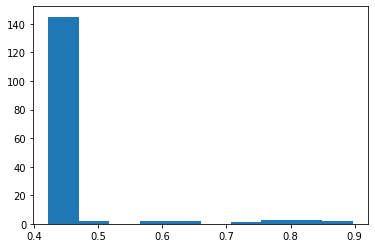

In [ ]:
ysiam = siamese.predict([x_test_old, x_test_new])
_ = plt.hist(ysiam)

In [ ]:
siamese.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 108, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_8 (InputLayer)           [(None, 108, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_4 (Functional)           (None, 2048)         23587712    ['input_7[0][0]',                
                                                                  'input_8[0][0]']          

## Extract features using siamese extractor

In [ ]:
# Read images

first_n_imgs = 400

imgs_old = load_imgs_source(df, 'old', size=(128,108), gray=True, first_n = first_n_imgs, three_channels=True)
imgs_new = load_imgs_source(df, 'new', size=(128,108), gray=True, first_n = first_n_imgs, three_channels=True)

In [ ]:
siamese_extractor = Sequential([
    Input((108, 128, 3)),
    siamese.layers[2]
])

In [ ]:
siamese_old_feats = siamese_extractor.predict(imgs_old)
siamese_new_feats = siamese_extractor.predict(imgs_new)

13/13 [==============================] - 18s 1s/step


In [ ]:
siamese_tree = KDTree(siamese_new_feats, leaf_size=20, metric='minkowski')

# Evaluation

**Metrics for evaluation:**
  1. Top-K precision (K=1/5/10/30/50)

## SIFT method

In [ ]:
sift_match_path = '/content/drive/MyDrive/ColabNotebooks/DSIM/Progetto/IR_pickle/pkl_sift/'

### Metric 1: Number of matched keypoint

In [ ]:
sift_topk_match = np.stack(load_pkl(sift_match_path + 'sift_accuracy_topk_50_metric1_n_matches_400.pickle'))

In [ ]:
topk1_matches, topk3_matches , topk5_matches , topk10_matches, topk30_matches, topk50_matches = [sift_topk_match[:,:topk] for topk in [1,3,5,10,30,50]]

In [ ]:
acc_topk1 = np.array(np.unique(np.array([np.any(np.isin(topk1_matches[idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk3 = np.array(np.unique(np.array([np.any(np.isin(topk3_matches[idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk5 = np.array(np.unique(np.array([np.any(np.isin(topk5_matches[idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk10 = np.array(np.unique(np.array([np.any(np.isin(topk10_matches[idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk30 = np.array(np.unique(np.array([np.any(np.isin(topk30_matches[idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk50 = np.array(np.unique(np.array([np.any(np.isin(topk50_matches[idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()

In [ ]:
for acc_topk,k in zip([acc_topk1,acc_topk3,acc_topk5,acc_topk10,acc_topk30,acc_topk50], [1,3,5,10,30,50]):
  print('Accurcay Top-'+str(k))
  print('-', 'Negative:' if acc_topk[0][0]==0 else 'Positive:', acc_topk[0][1], ' - ', acc_topk[0][1]/400*100, '%' )
  print('-', 'Negative:' if acc_topk[1][0]==0 else 'Positive:', acc_topk[1][1], ' - ', acc_topk[1][1]/400*100, '%' )
  print()

Accurcay Top-1
- Negative: 392  -  98.0 %
- Positive: 8  -  2.0 %

Accurcay Top-3
- Negative: 385  -  96.25 %
- Positive: 15  -  3.75 %

Accurcay Top-5
- Negative: 376  -  94.0 %
- Positive: 24  -  6.0 %

Accurcay Top-10
- Negative: 354  -  88.5 %
- Positive: 46  -  11.5 %

Accurcay Top-30
- Negative: 310  -  77.5 %
- Positive: 90  -  22.5 %

Accurcay Top-50
- Negative: 286  -  71.5 %
- Positive: 114  -  28.499999999999996 %



### Metric 2: Sum of match similarities

In [ ]:
sift_topk_match = np.stack(load_pkl(sift_match_path + 'sift_accuracy_topk_50_metric2_sum_of_distances_400.pickle'))

In [ ]:
topk1_matches, topk3_matches , topk5_matches , topk10_matches, topk30_matches, topk50_matches = [sift_topk_match[:,:topk] for topk in [1,3,5,10,30,50]]

In [ ]:
acc_topk1 = np.array(np.unique(np.array([np.any(np.isin(topk1_matches[idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk3 = np.array(np.unique(np.array([np.any(np.isin(topk3_matches[idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk5 = np.array(np.unique(np.array([np.any(np.isin(topk5_matches[idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk10 = np.array(np.unique(np.array([np.any(np.isin(topk10_matches[idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk30 = np.array(np.unique(np.array([np.any(np.isin(topk30_matches[idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk50 = np.array(np.unique(np.array([np.any(np.isin(topk50_matches[idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()

In [ ]:
for acc_topk,k in zip([acc_topk1,acc_topk3,acc_topk5,acc_topk10,acc_topk30,acc_topk50], [1,3,5,10,30,50]):
  print('Accurcay Top-'+str(k))
  print('-', 'Negative:' if acc_topk[0][0]==0 else 'Positive:', acc_topk[0][1], ' - ', acc_topk[0][1]/400*100, '%' )
  print('-', 'Negative:' if acc_topk[1][0]==0 else 'Positive:', acc_topk[1][1], ' - ', acc_topk[1][1]/400*100, '%' )
  print()

Accurcay Top-1
- Negative: 390  -  97.5 %
- Positive: 10  -  2.5 %

Accurcay Top-3
- Negative: 379  -  94.75 %
- Positive: 21  -  5.25 %

Accurcay Top-5
- Negative: 374  -  93.5 %
- Positive: 26  -  6.5 %

Accurcay Top-10
- Negative: 356  -  89.0 %
- Positive: 44  -  11.0 %

Accurcay Top-30
- Negative: 308  -  77.0 %
- Positive: 92  -  23.0 %

Accurcay Top-50
- Negative: 283  -  70.75 %
- Positive: 117  -  29.25 %



### Metric 3: Avg of match similarities

In [ ]:
sift_topk_match = np.stack(load_pkl(sift_match_path + 'sift_accuracy_topk_50_metric3_mean_of_distances_400.pickle'))

In [ ]:
topk1_matches, topk3_matches , topk5_matches , topk10_matches, topk30_matches, topk50_matches = [sift_topk_match[:,:topk] for topk in [1,3,5,10,30,50]]

In [ ]:
acc_topk1 = np.array(np.unique(np.array([np.any(np.isin(topk1_matches[idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk3 = np.array(np.unique(np.array([np.any(np.isin(topk3_matches[idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk5 = np.array(np.unique(np.array([np.any(np.isin(topk5_matches[idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk10 = np.array(np.unique(np.array([np.any(np.isin(topk10_matches[idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk30 = np.array(np.unique(np.array([np.any(np.isin(topk30_matches[idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk50 = np.array(np.unique(np.array([np.any(np.isin(topk50_matches[idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()

In [ ]:
for acc_topk,k in zip([acc_topk1,acc_topk3,acc_topk5,acc_topk10,acc_topk30,acc_topk50], [1,3,5,10,30,50]):
  print('Accurcay Top-'+str(k))
  print('-', 'Negative:' if acc_topk[0][0]==0 else 'Positive:', acc_topk[0][1], ' - ', acc_topk[0][1]/400*100, '%' )
  print('-', 'Negative:' if acc_topk[1][0]==0 else 'Positive:', acc_topk[1][1], ' - ', acc_topk[1][1]/400*100, '%' )
  print()

Accurcay Top-1
- Negative: 398  -  99.5 %
- Positive: 2  -  0.5 %

Accurcay Top-3
- Negative: 395  -  98.75 %
- Positive: 5  -  1.25 %

Accurcay Top-5
- Negative: 391  -  97.75 %
- Positive: 9  -  2.25 %

Accurcay Top-10
- Negative: 375  -  93.75 %
- Positive: 25  -  6.25 %

Accurcay Top-30
- Negative: 333  -  83.25 %
- Positive: 67  -  16.75 %

Accurcay Top-50
- Negative: 294  -  73.5 %
- Positive: 106  -  26.5 %



## CNN method

### Standard Mode

In [ ]:
topk1_matches, topk3_matches , topk5_matches , topk10_matches, topk30_matches, topk50_matches = [tree_query(resnet50_tree, resnet50_imgs_old_feats, k=topk) for topk in [1,3,5,10,30,50]]

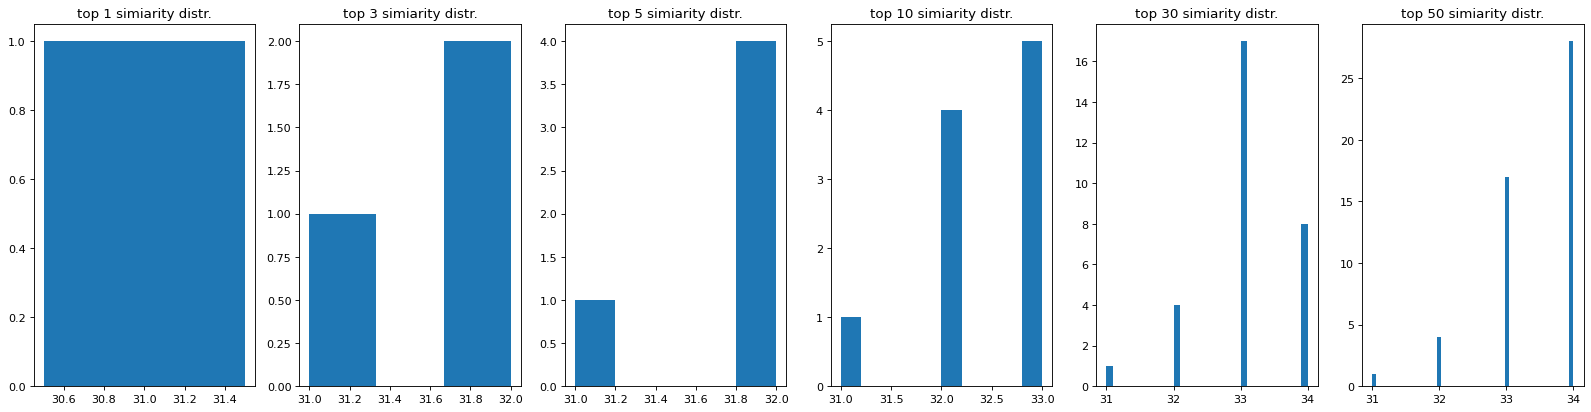

In [ ]:
plt.figure(figsize=(25, 6), dpi=80)
plt.subplot(1,6,1); plt.hist(topk1_matches[0].mean(axis=0).astype('uint8'), bins=1); plt.title('top 1 simiarity distr.')
plt.subplot(1,6,2); plt.hist(topk3_matches[0].mean(axis=0).astype('uint8'), bins=3); plt.title('top 3 simiarity distr.')
plt.subplot(1,6,3); plt.hist(topk5_matches[0].mean(axis=0).astype('uint8'), bins=5); plt.title('top 5 simiarity distr.')
plt.subplot(1,6,4); plt.hist(topk10_matches[0].mean(axis=0).astype('uint8'), bins=10); plt.title('top 10 simiarity distr.')
plt.subplot(1,6,5); plt.hist(topk30_matches[0].mean(axis=0).astype('uint8'), bins=30); plt.title('top 30 simiarity distr.')
plt.subplot(1,6,6); plt.hist(topk50_matches[0].mean(axis=0).astype('uint8'), bins=50); plt.title('top 50 simiarity distr.')
plt.show();

In [ ]:
acc_topk1 = np.array(np.unique(np.array([np.any(np.isin(topk1_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk3 = np.array(np.unique(np.array([np.any(np.isin(topk3_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk5 = np.array(np.unique(np.array([np.any(np.isin(topk5_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk10 = np.array(np.unique(np.array([np.any(np.isin(topk10_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk30 = np.array(np.unique(np.array([np.any(np.isin(topk30_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk50 = np.array(np.unique(np.array([np.any(np.isin(topk50_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()

In [ ]:
for acc_topk,k in zip([acc_topk1,acc_topk3,acc_topk5,acc_topk10,acc_topk30,acc_topk50], [1,3,5,10,30,50]):
  print('Accurcay Top-'+str(k))
  print('-', 'Negative:' if acc_topk[0][0]==0 else 'Positive:', acc_topk[0][1], ' - ', acc_topk[0][1]/400*100, '% - ' )
  print('-', 'Negative:' if acc_topk[1][0]==0 else 'Positive:', acc_topk[1][1], ' - ', acc_topk[1][1]/400*100, '% - ' )
  print()

Accurcay Top-1
- Negative: 393  -  98.25 % - 
- Positive: 7  -  1.7500000000000002 % - 

Accurcay Top-3
- Negative: 383  -  95.75 % - 
- Positive: 17  -  4.25 % - 

Accurcay Top-5
- Negative: 379  -  94.75 % - 
- Positive: 21  -  5.25 % - 

Accurcay Top-10
- Negative: 366  -  91.5 % - 
- Positive: 34  -  8.5 % - 

Accurcay Top-30
- Negative: 322  -  80.5 % - 
- Positive: 78  -  19.5 % - 

Accurcay Top-50
- Negative: 290  -  72.5 % - 
- Positive: 110  -  27.500000000000004 % - 



### Grid 3x3 System

#### Weighted mean only

In [ ]:
topk1_matches, topk3_matches , topk5_matches , topk10_matches, topk30_matches, topk50_matches = [tree_query(resnet50_tree_tiles_w_mean, resnet50_imgs_tiles_w_mean_old_feats, k=topk) for topk in [1,3,5,10,30,50]]

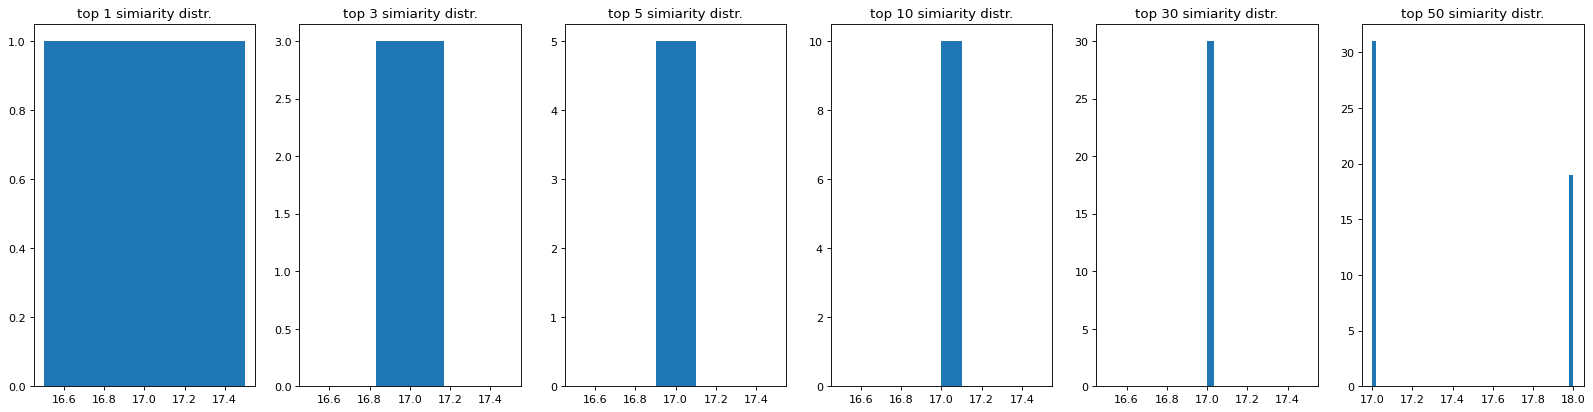

In [ ]:
plt.figure(figsize=(25, 6), dpi=80)
plt.subplot(1,6,1); plt.hist(topk1_matches[0].mean(axis=0).astype('uint8'), bins=1); plt.title('top 1 simiarity distr.')
plt.subplot(1,6,2); plt.hist(topk3_matches[0].mean(axis=0).astype('uint8'), bins=3); plt.title('top 3 simiarity distr.')
plt.subplot(1,6,3); plt.hist(topk5_matches[0].mean(axis=0).astype('uint8'), bins=5); plt.title('top 5 simiarity distr.')
plt.subplot(1,6,4); plt.hist(topk10_matches[0].mean(axis=0).astype('uint8'), bins=10); plt.title('top 10 simiarity distr.')
plt.subplot(1,6,5); plt.hist(topk30_matches[0].mean(axis=0).astype('uint8'), bins=30); plt.title('top 30 simiarity distr.')
plt.subplot(1,6,6); plt.hist(topk50_matches[0].mean(axis=0).astype('uint8'), bins=50); plt.title('top 50 simiarity distr.')
plt.show();

In [ ]:
acc_topk1 = np.array(np.unique(np.array([np.any(np.isin(topk1_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk3 = np.array(np.unique(np.array([np.any(np.isin(topk3_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk5 = np.array(np.unique(np.array([np.any(np.isin(topk5_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk10 = np.array(np.unique(np.array([np.any(np.isin(topk10_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk30 = np.array(np.unique(np.array([np.any(np.isin(topk30_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk50 = np.array(np.unique(np.array([np.any(np.isin(topk50_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()

In [ ]:
for acc_topk,k in zip([acc_topk1,acc_topk3,acc_topk5,acc_topk10,acc_topk30,acc_topk50], [1,3,5,10,30,50]):
  print('Accurcay Top-'+str(k))
  print('-', 'Negative:' if acc_topk[0][0]==0 else 'Positive:', acc_topk[0][1], ' - ', acc_topk[0][1]/400*100, '% - ' )
  if acc_topk.shape[0]>1:
    print('-', 'Negative:' if acc_topk[1][0]==0 else 'Positive:', acc_topk[1][1], ' - ', acc_topk[1][1]/400*100, '% - ' )
  print()

Accurcay Top-1
- Negative: 399  -  99.75 % - 
- Positive: 1  -  0.25 % - 

Accurcay Top-3
- Negative: 392  -  98.0 % - 
- Positive: 8  -  2.0 % - 

Accurcay Top-5
- Negative: 391  -  97.75 % - 
- Positive: 9  -  2.25 % - 

Accurcay Top-10
- Negative: 384  -  96.0 % - 
- Positive: 16  -  4.0 % - 

Accurcay Top-30
- Negative: 362  -  90.5 % - 
- Positive: 38  -  9.5 % - 

Accurcay Top-50
- Negative: 342  -  85.5 % - 
- Positive: 58  -  14.499999999999998 % - 



#### Custom LocCNN Fetaures
Weighted mean features + full image features

In [ ]:
topk1_matches, topk3_matches , topk5_matches , topk10_matches, topk30_matches, topk50_matches = [tree_query(resnet50_tree_tiles_loc_w_mean, resnet50_imgs_tiles_loc_w_mean_old_feats, k=topk) for topk in [1,3,5,10,30,50]]

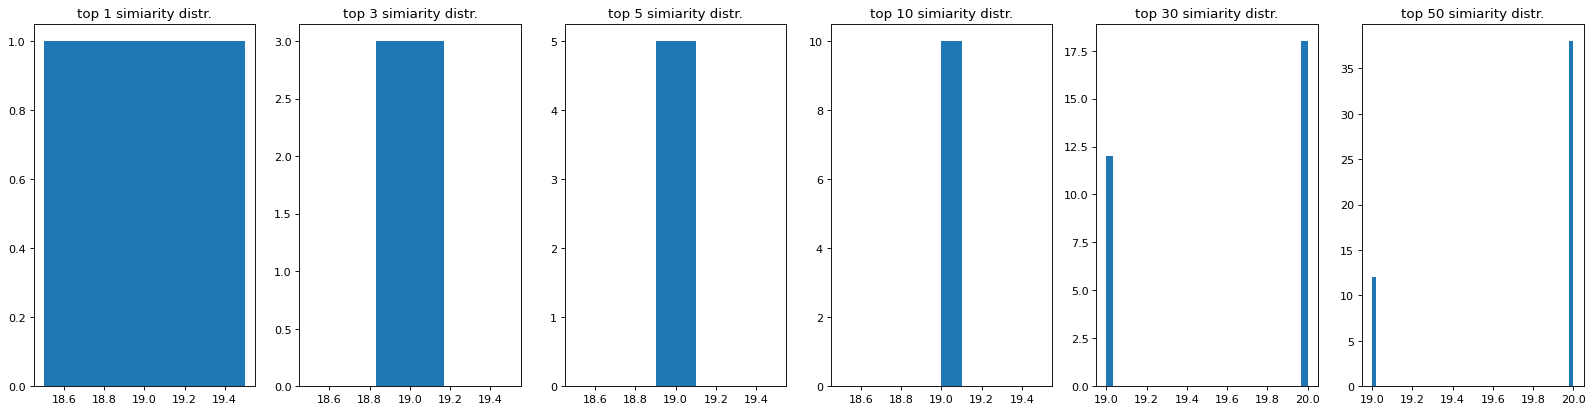

In [ ]:
plt.figure(figsize=(25, 6), dpi=80)
plt.subplot(1,6,1); plt.hist(topk1_matches[0].mean(axis=0).astype('uint8'), bins=1); plt.title('top 1 simiarity distr.')
plt.subplot(1,6,2); plt.hist(topk3_matches[0].mean(axis=0).astype('uint8'), bins=3); plt.title('top 3 simiarity distr.')
plt.subplot(1,6,3); plt.hist(topk5_matches[0].mean(axis=0).astype('uint8'), bins=5); plt.title('top 5 simiarity distr.')
plt.subplot(1,6,4); plt.hist(topk10_matches[0].mean(axis=0).astype('uint8'), bins=10); plt.title('top 10 simiarity distr.')
plt.subplot(1,6,5); plt.hist(topk30_matches[0].mean(axis=0).astype('uint8'), bins=30); plt.title('top 30 simiarity distr.')
plt.subplot(1,6,6); plt.hist(topk50_matches[0].mean(axis=0).astype('uint8'), bins=50); plt.title('top 50 simiarity distr.')
plt.show();

In [ ]:
acc_topk1 = np.array(np.unique(np.array([np.any(np.isin(topk1_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk3 = np.array(np.unique(np.array([np.any(np.isin(topk3_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk5 = np.array(np.unique(np.array([np.any(np.isin(topk5_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk10 = np.array(np.unique(np.array([np.any(np.isin(topk10_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk30 = np.array(np.unique(np.array([np.any(np.isin(topk30_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk50 = np.array(np.unique(np.array([np.any(np.isin(topk50_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()

In [ ]:
for acc_topk,k in zip([acc_topk1,acc_topk3,acc_topk5,acc_topk10,acc_topk30,acc_topk50], [1,3,5,10,30,50]):
  print('Accurcay Top-'+str(k))
  print('-', 'Negative:' if acc_topk[0][0]==0 else 'Positive:', acc_topk[0][1], ' - ', acc_topk[0][1]/400*100, '% - ' )
  if acc_topk.shape[0]>1:
    print('-', 'Negative:' if acc_topk[1][0]==0 else 'Positive:', acc_topk[1][1], ' - ', acc_topk[1][1]/400*100, '% - ' )
  print()

Accurcay Top-1
- Negative: 395  -  98.75 % - 
- Positive: 5  -  1.25 % - 

Accurcay Top-3
- Negative: 389  -  97.25 % - 
- Positive: 11  -  2.75 % - 

Accurcay Top-5
- Negative: 387  -  96.75 % - 
- Positive: 13  -  3.25 % - 

Accurcay Top-10
- Negative: 374  -  93.5 % - 
- Positive: 26  -  6.5 % - 

Accurcay Top-30
- Negative: 342  -  85.5 % - 
- Positive: 58  -  14.499999999999998 % - 

Accurcay Top-50
- Negative: 319  -  79.75 % - 
- Positive: 81  -  20.25 % - 



#### Standard LocCNN Features
Mean central tile + full image

In [ ]:
topk1_matches, topk3_matches , topk5_matches , topk10_matches, topk30_matches, topk50_matches = [tree_query(resnet50_tree_central_loc_w_mean, resnet50_imgs_central_loc_w_mean_old_feats, k=topk) for topk in [1,3,5,10,30,50]]

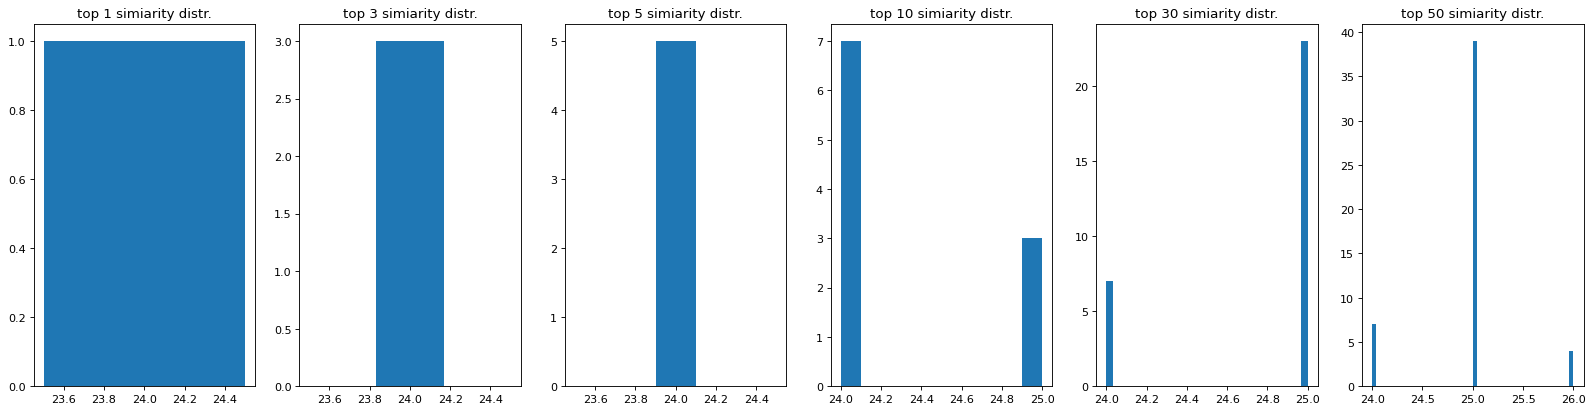

In [ ]:
plt.figure(figsize=(25, 6), dpi=80)
plt.subplot(1,6,1); plt.hist(topk1_matches[0].mean(axis=0).astype('uint8'), bins=1); plt.title('top 1 simiarity distr.')
plt.subplot(1,6,2); plt.hist(topk3_matches[0].mean(axis=0).astype('uint8'), bins=3); plt.title('top 3 simiarity distr.')
plt.subplot(1,6,3); plt.hist(topk5_matches[0].mean(axis=0).astype('uint8'), bins=5); plt.title('top 5 simiarity distr.')
plt.subplot(1,6,4); plt.hist(topk10_matches[0].mean(axis=0).astype('uint8'), bins=10); plt.title('top 10 simiarity distr.')
plt.subplot(1,6,5); plt.hist(topk30_matches[0].mean(axis=0).astype('uint8'), bins=30); plt.title('top 30 simiarity distr.')
plt.subplot(1,6,6); plt.hist(topk50_matches[0].mean(axis=0).astype('uint8'), bins=50); plt.title('top 50 simiarity distr.')
plt.show();

In [ ]:
acc_topk1 = np.array(np.unique(np.array([np.any(np.isin(topk1_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk3 = np.array(np.unique(np.array([np.any(np.isin(topk3_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk5 = np.array(np.unique(np.array([np.any(np.isin(topk5_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk10 = np.array(np.unique(np.array([np.any(np.isin(topk10_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk30 = np.array(np.unique(np.array([np.any(np.isin(topk30_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk50 = np.array(np.unique(np.array([np.any(np.isin(topk50_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()

In [ ]:
for acc_topk,k in zip([acc_topk1,acc_topk3,acc_topk5,acc_topk10,acc_topk30,acc_topk50], [1,3,5,10,30,50]):
  print('Accurcay Top-'+str(k))
  print('-', 'Negative:' if acc_topk[0][0]==0 else 'Positive:', acc_topk[0][1], ' - ', acc_topk[0][1]/400*100, '% - ' )
  if acc_topk.shape[0]>1:
    print('-', 'Negative:' if acc_topk[1][0]==0 else 'Positive:', acc_topk[1][1], ' - ', acc_topk[1][1]/400*100, '% - ' )
  print()

Accurcay Top-1
- Negative: 394  -  98.5 % - 
- Positive: 6  -  1.5 % - 

Accurcay Top-3
- Negative: 389  -  97.25 % - 
- Positive: 11  -  2.75 % - 

Accurcay Top-5
- Negative: 383  -  95.75 % - 
- Positive: 17  -  4.25 % - 

Accurcay Top-10
- Negative: 364  -  91.0 % - 
- Positive: 36  -  9.0 % - 

Accurcay Top-30
- Negative: 333  -  83.25 % - 
- Positive: 67  -  16.75 % - 

Accurcay Top-50
- Negative: 304  -  76.0 % - 
- Positive: 96  -  24.0 % - 



## VLAD descriptors

### KMeans 128

In [ ]:
topk1_matches, topk3_matches , topk5_matches , topk10_matches, topk30_matches, topk50_matches = [tree_query(vlad_new_kdtree, vlad_flat_old, k=topk) for topk in [1,3,5,10,30,50]]

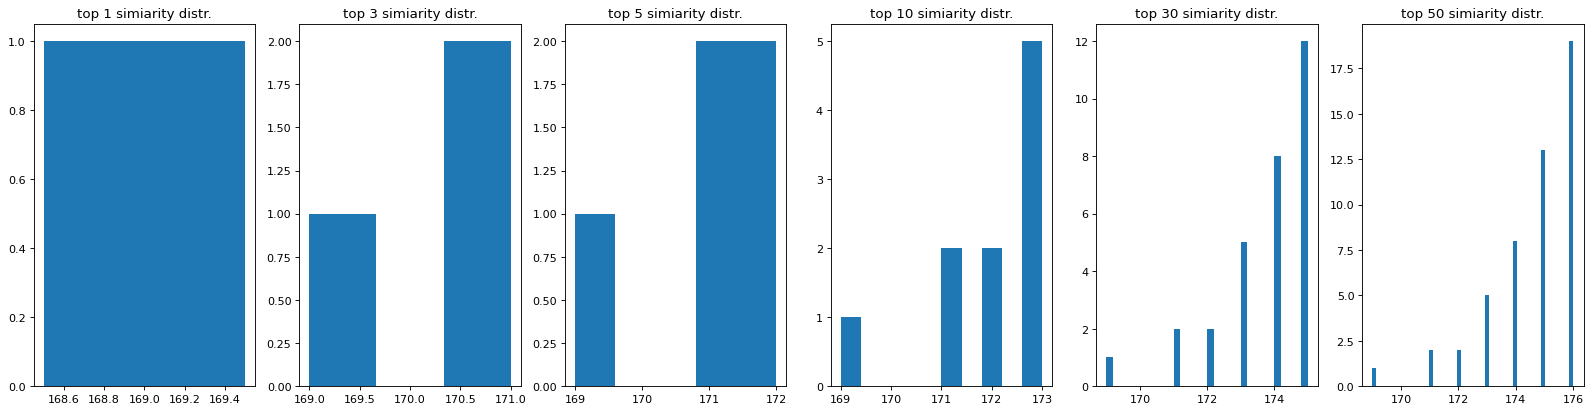

In [ ]:
plt.figure(figsize=(25, 6), dpi=80)
plt.subplot(1,6,1); plt.hist(topk1_matches[0].mean(axis=0).astype('uint8'), bins=1); plt.title('top 1 simiarity distr.')
plt.subplot(1,6,2); plt.hist(topk3_matches[0].mean(axis=0).astype('uint8'), bins=3); plt.title('top 3 simiarity distr.')
plt.subplot(1,6,3); plt.hist(topk5_matches[0].mean(axis=0).astype('uint8'), bins=5); plt.title('top 5 simiarity distr.')
plt.subplot(1,6,4); plt.hist(topk10_matches[0].mean(axis=0).astype('uint8'), bins=10); plt.title('top 10 simiarity distr.')
plt.subplot(1,6,5); plt.hist(topk30_matches[0].mean(axis=0).astype('uint8'), bins=30); plt.title('top 30 simiarity distr.')
plt.subplot(1,6,6); plt.hist(topk50_matches[0].mean(axis=0).astype('uint8'), bins=50); plt.title('top 50 simiarity distr.')
plt.show();

In [ ]:
acc_topk1 = np.array(np.unique(np.array([np.any(np.isin(topk1_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk3 = np.array(np.unique(np.array([np.any(np.isin(topk3_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk5 = np.array(np.unique(np.array([np.any(np.isin(topk5_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk10 = np.array(np.unique(np.array([np.any(np.isin(topk10_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk30 = np.array(np.unique(np.array([np.any(np.isin(topk30_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk50 = np.array(np.unique(np.array([np.any(np.isin(topk50_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()

In [ ]:
for acc_topk,k in zip([acc_topk1,acc_topk3,acc_topk5,acc_topk10,acc_topk30,acc_topk50], [1,3,5,10,30,50]):
  print('Accurcay Top-'+str(k))
  print('-', 'Negative:' if acc_topk[0][0]==0 else 'Positive:', acc_topk[0][1], ' - ', acc_topk[0][1]/400*100, '% - ' )
  print('-', 'Negative:' if acc_topk[1][0]==0 else 'Positive:', acc_topk[1][1], ' - ', acc_topk[1][1]/400*100, '% - ' )
  print()

Accurcay Top-1
- Negative: 382  -  95.5 %
- Positive: 18  -  4.5 %

Accurcay Top-3
- Negative: 359  -  89.75 %
- Positive: 41  -  10.25 %

Accurcay Top-5
- Negative: 348  -  87.0 %
- Positive: 52  -  13.0 %

Accurcay Top-10
- Negative: 320  -  80.0 %
- Positive: 80  -  20.0 %

Accurcay Top-30
- Negative: 262  -  65.5 %
- Positive: 138  -  34.5 %

Accurcay Top-50
- Negative: 229  -  57.25 %
- Positive: 171  -  42.75 %



## Siamese embedding

In [ ]:
topk1_matches, topk3_matches , topk5_matches , topk10_matches, topk30_matches, topk50_matches = [tree_query(siamese_tree, siamese_old_feats, k=topk) for topk in [1,3,5,10,30,50]]

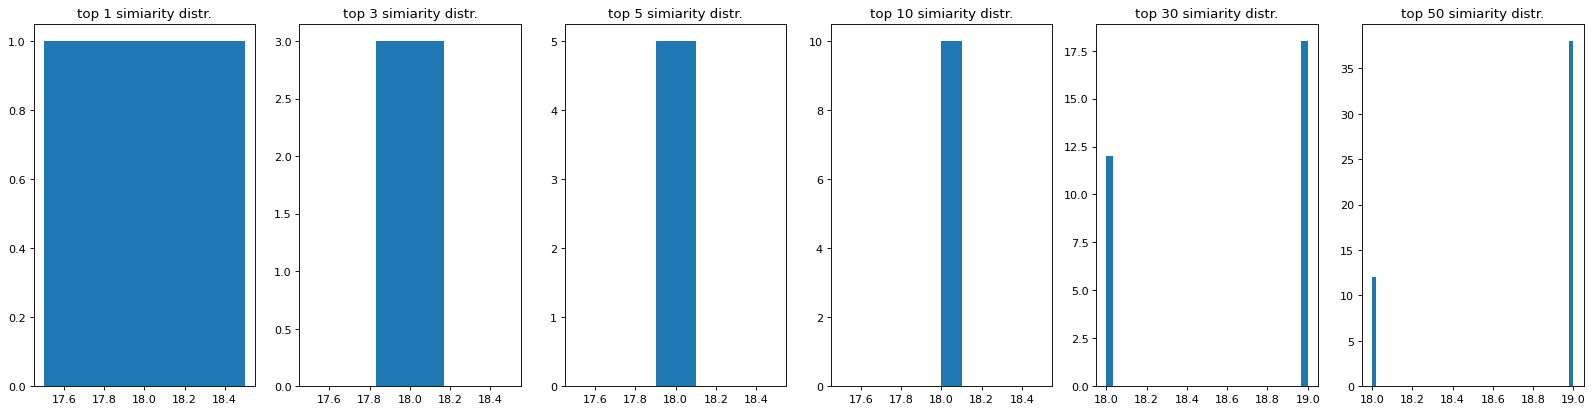

In [ ]:
plt.figure(figsize=(25, 6), dpi=80)
plt.subplot(1,6,1); plt.hist(topk1_matches[0].mean(axis=0).astype('uint8'), bins=1); plt.title('top 1 simiarity distr.')
plt.subplot(1,6,2); plt.hist(topk3_matches[0].mean(axis=0).astype('uint8'), bins=3); plt.title('top 3 simiarity distr.')
plt.subplot(1,6,3); plt.hist(topk5_matches[0].mean(axis=0).astype('uint8'), bins=5); plt.title('top 5 simiarity distr.')
plt.subplot(1,6,4); plt.hist(topk10_matches[0].mean(axis=0).astype('uint8'), bins=10); plt.title('top 10 simiarity distr.')
plt.subplot(1,6,5); plt.hist(topk30_matches[0].mean(axis=0).astype('uint8'), bins=30); plt.title('top 30 simiarity distr.')
plt.subplot(1,6,6); plt.hist(topk50_matches[0].mean(axis=0).astype('uint8'), bins=50); plt.title('top 50 simiarity distr.')
plt.show();

In [ ]:
acc_topk1 = np.array(np.unique(np.array([np.any(np.isin(topk1_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk3 = np.array(np.unique(np.array([np.any(np.isin(topk3_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk5 = np.array(np.unique(np.array([np.any(np.isin(topk5_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk10 = np.array(np.unique(np.array([np.any(np.isin(topk10_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk30 = np.array(np.unique(np.array([np.any(np.isin(topk30_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()
acc_topk50 = np.array(np.unique(np.array([np.any(np.isin(topk50_matches[1][idx], idx)) for idx in range(first_n_imgs)]), return_counts=True)).transpose()

In [ ]:
for acc_topk,k in zip([acc_topk1,acc_topk3,acc_topk5,acc_topk10,acc_topk30,acc_topk50], [1,3,5,10,30,50]):
  print('Accurcay Top-'+str(k))
  print('-', 'Negative:' if acc_topk[0][0]==0 else 'Positive:', acc_topk[0][1], ' - ', acc_topk[0][1]/400*100, '% - ' )
  print('-', 'Negative:' if acc_topk[1][0]==0 else 'Positive:', acc_topk[1][1], ' - ', acc_topk[1][1]/400*100, '% - ' )
  print()

Accurcay Top-1
- Negative: 399  -  99.75 % - 
- Positive: 1  -  0.25 % - 

Accurcay Top-3
- Negative: 396  -  99.0 % - 
- Positive: 4  -  1.0 % - 

Accurcay Top-5
- Negative: 394  -  98.5 % - 
- Positive: 6  -  1.5 % - 

Accurcay Top-10
- Negative: 390  -  97.5 % - 
- Positive: 10  -  2.5 % - 

Accurcay Top-30
- Negative: 368  -  92.0 % - 
- Positive: 32  -  8.0 % - 

Accurcay Top-50
- Negative: 345  -  86.25 % - 
- Positive: 55  -  13.750000000000002 % - 



<hr><hr><hr>

# DEMO

In [4]:
# Modificare con il proprio percorso

pkl_base_path = '/content/drive/MyDrive/ColabNotebooks/DSIM/Progetto/IR_pickle/'

In [34]:
test_im_idx = 1

In [6]:
topk = 8

In [10]:
# Read images

first_n_imgs = 400

imgs_old = load_imgs('old', size=(450,380), gray=True, first_n = first_n_imgs)
imgs_new = load_imgs('new', size=None, gray=True, first_n = first_n_imgs)

## SIFT

### Metric 1: n. of matches

In [35]:
sift_topk_match = np.stack(load_pkl(pkl_base_path + 'pkl_sift/sift_accuracy_topk_50_metric1_n_matches_400.pickle'))

In [36]:
imquery = imgs_old[test_im_idx]
top5_match = np.stack([imgs_new[i] for i in sift_topk_match[test_im_idx][:topk]])

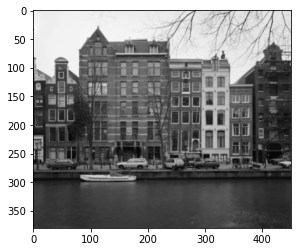

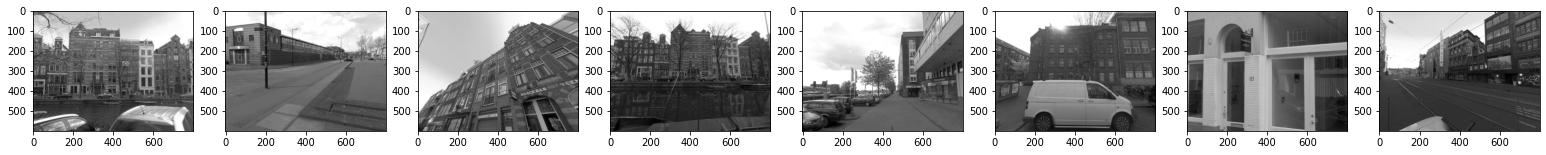

In [37]:
plt.imshow(imquery, cmap='gray'); plt.show();
plt.figure(figsize=(27,6))
for i in range(topk):
  plt.subplot(1,topk,i+1); plt.imshow(top5_match[i], cmap='gray');
plt.show()

### Metric 2: sum of matches similarity

In [54]:
sift_topk_match = np.stack(load_pkl(pkl_base_path + 'pkl_sift/sift_accuracy_topk_50_metric2_sum_of_distances_400.pickle'))

In [55]:
imquery = imgs_old[test_im_idx]
top5_match = np.stack([imgs_new[i] for i in sift_topk_match[test_im_idx][:topk]])

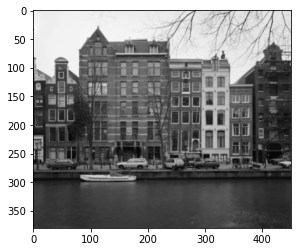

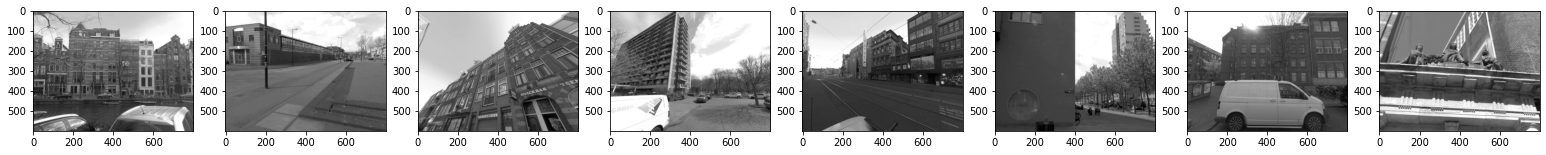

In [56]:
plt.imshow(imquery, cmap='gray'); plt.show();
plt.figure(figsize=(27,6))
for i in range(topk):
  plt.subplot(1,topk,i+1); plt.imshow(top5_match[i], cmap='gray');
plt.show()

### Metric 3: avg of matches similarity

In [57]:
sift_topk_match = np.stack(load_pkl(pkl_base_path + 'pkl_sift/sift_accuracy_topk_50_metric3_mean_of_distances_400.pickle'))

In [58]:
imquery = imgs_old[test_im_idx]
top5_match = np.stack([imgs_new[i] for i in sift_topk_match[test_im_idx][:topk]])

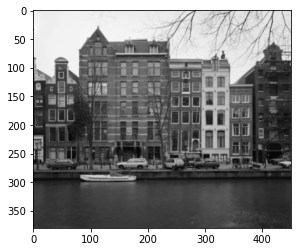

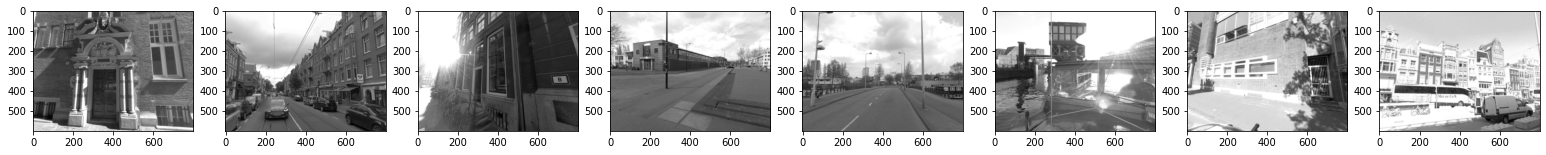

In [59]:
plt.imshow(imquery, cmap='gray'); plt.show();
plt.figure(figsize=(27,6))
for i in range(topk):
  plt.subplot(1,topk,i+1); plt.imshow(top5_match[i], cmap='gray');
plt.show()

## CNN features

### Standard mode

In [44]:
cnn_features_old = np.stack(load_pkl(pkl_base_path + 'pkl_resnet/resnet50_imgs_old_feats_first400.pickle'))
cnn_features_new = np.stack(load_pkl(pkl_base_path + 'pkl_resnet/resnet50_imgs_new_feats_first400.pickle'))
cnn_tree = KDTree(cnn_features_new, leaf_size=20, metric='minkowski')

In [21]:
im_query = imgs_old[test_im_idx]
feat_query = cnn_features_old[test_im_idx]
top5_match = np.stack([imgs_new[i] for i in tree_query(cnn_tree, np.expand_dims(feat_query, axis=0), topk)[1].flatten()])

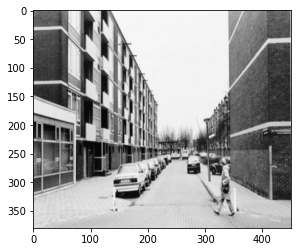

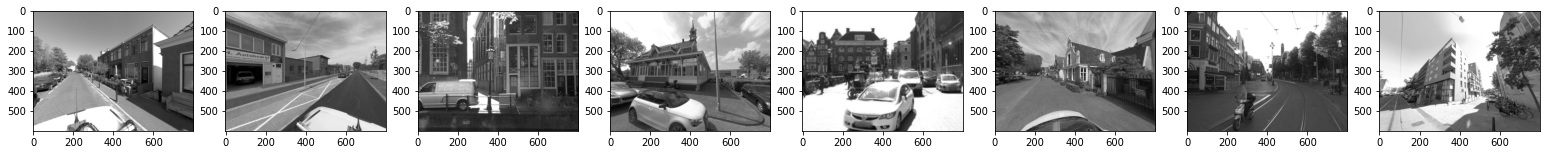

In [22]:
plt.imshow(im_query, cmap='gray'); plt.show();
plt.figure(figsize=(27,6))
for i in range(topk):
  plt.subplot(1,topk,i+1); plt.imshow(top5_match[i], cmap='gray');
plt.show()

### Tiles - Custom Loc

In [45]:
cnn_features_old = np.stack(load_pkl(pkl_base_path + 'pkl_resnet/resnet50_imgs_old_feats_first400.pickle'))
cnn_features_new = np.stack(load_pkl(pkl_base_path + 'pkl_resnet/resnet50_imgs_new_feats_first400.pickle'))
cnn_features_tiles_old = np.stack(load_pkl(pkl_base_path + 'pkl_resnet/resnet50_imgs_tiles9_old_feats_first400.pickle'))
cnn_features_tiles_new = np.stack(load_pkl(pkl_base_path + 'pkl_resnet/resnet50_imgs_tiles9_new_feats_first400.pickle'))

In [46]:
weights = np.array([1,2,1, 2,4,2, 1,2,1])
cnn_features_tiles_old = resnet_tiles_wmean(cnn_features_tiles_old, weights)
cnn_features_tiles_new = resnet_tiles_wmean(cnn_features_tiles_new, weights)

loc_w = {'wloc':0.7, 'wfull':0.3}
cnn_features_old = cnn_features_tiles_old*loc_w['wloc'] + cnn_features_old*loc_w['wfull']
cnn_features_new = cnn_features_tiles_new*loc_w['wloc'] + cnn_features_new*loc_w['wfull']

cnn_tree = KDTree(cnn_features_new, leaf_size=20, metric='minkowski')

In [47]:
im_query = imgs_old[test_im_idx]
feat_query = cnn_features_old[test_im_idx]
top5_match = np.stack([imgs_new[i] for i in tree_query(cnn_tree, np.expand_dims(feat_query, axis=0), topk)[1].flatten()])

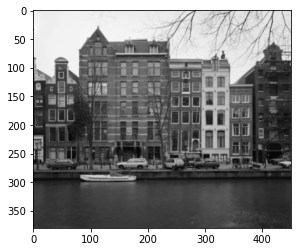

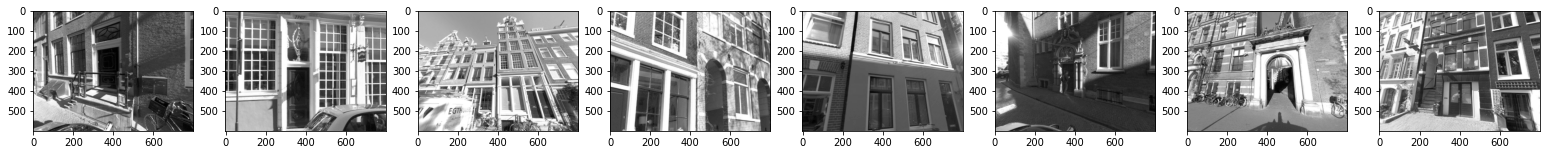

In [48]:
plt.imshow(im_query, cmap='gray'); plt.show();
plt.figure(figsize=(27,6))
for i in range(topk):
  plt.subplot(1,topk,i+1); plt.imshow(top5_match[i], cmap='gray');
plt.show()

### Tiles - Standard Loc

In [49]:
cnn_features_old = np.stack(load_pkl(pkl_base_path + 'pkl_resnet/resnet50_imgs_old_feats_first400.pickle'))
cnn_features_new = np.stack(load_pkl(pkl_base_path + 'pkl_resnet/resnet50_imgs_new_feats_first400.pickle'))
cnn_features_tiles_old = np.stack(load_pkl(pkl_base_path + 'pkl_resnet/resnet50_imgs_tiles9_old_feats_first400.pickle'))
cnn_features_tiles_new = np.stack(load_pkl(pkl_base_path + 'pkl_resnet/resnet50_imgs_tiles9_new_feats_first400.pickle'))

In [50]:
loc_w = {'wloc':0.5, 'wfull':0.5}
cnn_features_old = cnn_features_tiles_old[:,4,:]*loc_w['wloc'] + cnn_features_old*loc_w['wfull']
cnn_features_new = cnn_features_tiles_new[:,4,:]*loc_w['wloc'] + cnn_features_new*loc_w['wfull']

cnn_tree = KDTree(cnn_features_new, leaf_size=20, metric='minkowski')

In [51]:
im_query = imgs_old[test_im_idx]
feat_query = cnn_features_old[test_im_idx]
top5_match = np.stack([imgs_new[i] for i in tree_query(cnn_tree, np.expand_dims(feat_query, axis=0), topk)[1].flatten()])

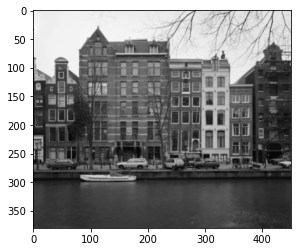

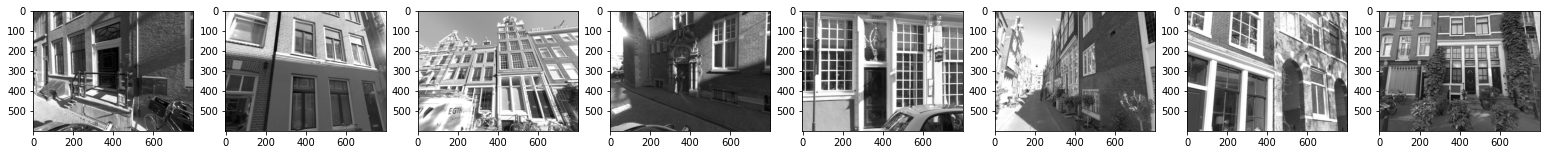

In [52]:
plt.imshow(im_query, cmap='gray'); plt.show();
plt.figure(figsize=(27,6))
for i in range(topk):
  plt.subplot(1,topk,i+1); plt.imshow(top5_match[i], cmap='gray');
plt.show()

## VLAD

In [60]:
vlad_old = load_pkl(pkl_base_path + 'pkl_vlad_kmeans/vlad_normalized_kmeans128_sift_old_first400.pickle')
vlad_new = load_pkl(pkl_base_path + 'pkl_vlad_kmeans/vlad_normalized_kmeans128_sift_new_first400.pickle')
vlad_old = np.stack(vlad.flatten() for vlad in vlad_old)
vlad_new = np.stack(vlad.flatten() for vlad in vlad_new)
vlad_old[np.isnan(vlad_old)] = 0
vlad_new[np.isnan(vlad_new)] = 0
vlad_old[np.isinf(vlad_old)] = np.finfo('float64').max
vlad_new[np.isinf(vlad_new)] = np.finfo('float64').max
vlad_tree = KDTree(vlad_new, leaf_size=20, metric='minkowski')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [61]:
im_query = imgs_old[test_im_idx]
feat_query = vlad_old[test_im_idx]
top5_match = np.stack([imgs_new[i] for i in tree_query(vlad_tree, np.expand_dims(feat_query, axis=0), topk)[1].flatten()])

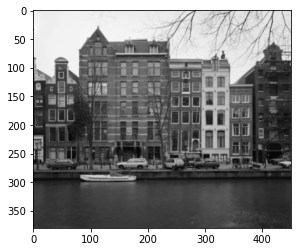

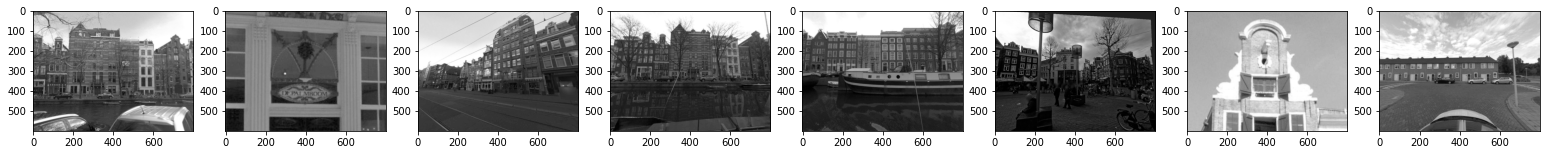

In [62]:
plt.imshow(im_query, cmap='gray'); plt.show();
plt.figure(figsize=(27,6))
for i in range(topk):
  plt.subplot(1,topk,i+1); plt.imshow(top5_match[i], cmap='gray');
plt.show()